# Определение возраста покупателей

## Исследовательский анализ данных

**Заказчик исследования** — cетевой супермаркет «Хлеб-Соль».

**Цель исследования**  — внедрить систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы, контролировать добросовестность кассиров при продаже алкоголя.

**Задача исследования**  — построить модель, которая по фотографии определит приблизительный возраст человека.

In [1]:
# импорт библиотек и методов
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

In [2]:
# загрузка датасета с метками
df = pd.read_csv('/datasets/faces/labels.csv')
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
# просмотр типов данных
df.dtypes

file_name    object
real_age      int64
dtype: object

В исходном датасете 2 колонки: 
- `file_name` — название файла, в котором содержится изображение (тип данных *object*)
- `real_age` — возраст человека, изображённого на фотографии (тип данных *int64*)

In [5]:
# вывод статистик датасета
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


В датасете около 7600 изображений, средний возраст людей, изображенных на фотографиях — 31 год. Следовательно, большая часть посетителей сетевого супермаркета — юные/зрелые люди. Людей пожилого возраста меньше. Это может сказаться на предсказательной способности модели.

Аномальных статистик не имеется.

Создадим генератор данных и выведем размер изображений.

In [6]:
# формирование датагенератора
datagen = ImageDataGenerator(rescale=1/255)
path = '/datasets/faces/final_files/'

batch_size = 16
generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=path,
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),
    batch_size=batch_size,
    shuffle=True,
    class_mode='raw',
    seed=42
)

Found 7591 validated image filenames.


In [7]:
# вывод размрности одного изображения
features, target = next(generator)
features.shape

(16, 150, 150, 3)

Мы установили размер таргета в (150, 150), поэтому 2ая и 3я рамерности соответствующие. Изображение имеет три канала, в каждом батче 16 экземпляров.

Далее посмотрим на диаграмму распределния возрастов, чтобы понимать, с какими данными мы имеем дело.

[Text(0.5, 1.0, 'Age distribution')]

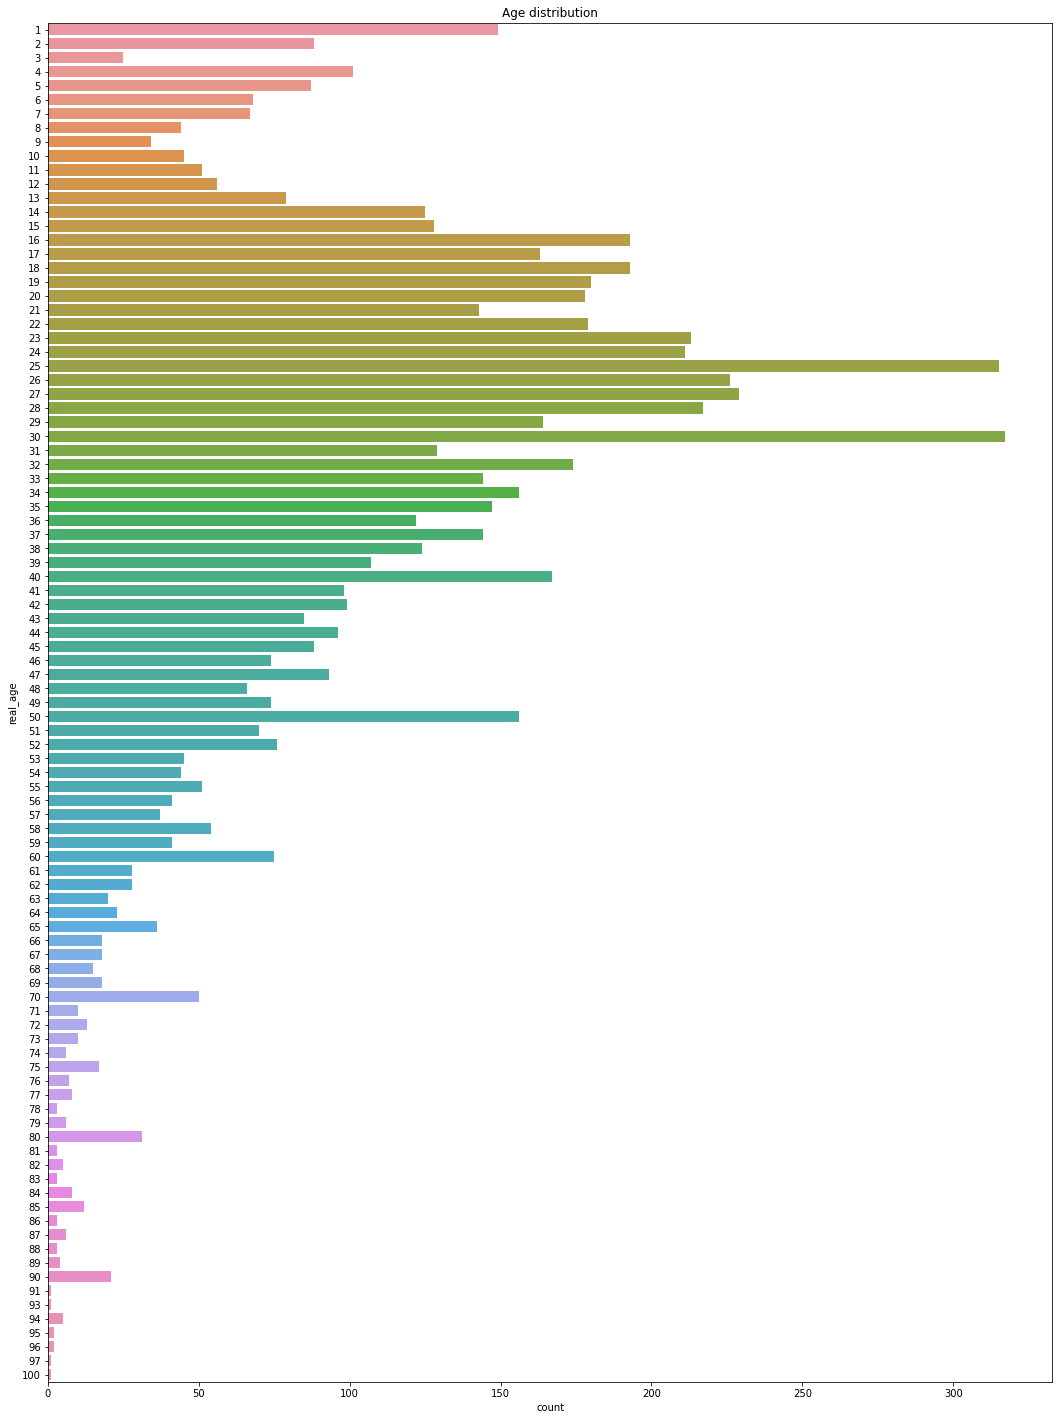

In [8]:
# построение графика разпределения возрастов
fig = plt.figure(figsize=(18,25))
sns.countplot(data=df, y='real_age').set(title='Age distribution')

Как и предполагали, значительную часть датасета составляют юные/зрелые люди. Распределение скошено вправо. Самый встречаемый возраст среди посетителей данного супермаркета — 25 и 30 лет.

Теперь визуально посмотрим на 16 изображений датасета.

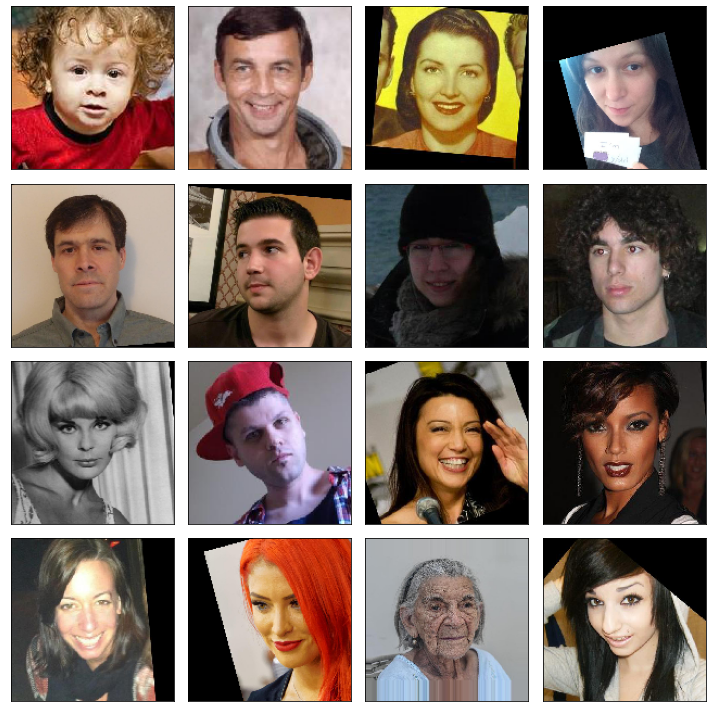

In [9]:
# выводим 16 изображений
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

В нашем распоряжении есть и цветные, и черно-белые фотографии. 
Некоторые из фотографий обрезаны, повёрнуты, размещены с поворотом на чёрном фоне.

**Вывод:**

Данные изучены и проанализированы.

## Обучение модели

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pandas as pd
from tensorflow.keras.applications.resnet import ResNet50

def load_train(path):
    df = pd.read_csv(path + f'/labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, 
                                 rescale=1/255,
                                 horizontal_flip=True,
                                 vertical_flip=True)
    
    train_datagen_flow = datagen.flow_from_dataframe(dataframe=df,
                                                     directory=path + f'/final_files/',
                                                     x_col='file_name',
                                                     y_col='real_age',
                                                     subset='training', 
                                                     batch_size=16,
                                                     target_size=(224,224),
                                                     class_mode='raw',
                                                     seed=12345)
    return train_datagen_flow


def load_test(path):
    df = pd.read_csv(path + f'/labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, 
                                 rescale=1/255)
    test_datagen_flow = datagen.flow_from_dataframe(dataframe=df,
                                                    directory=path + f'/final_files/',
                                                    x_col='file_name',
                                                    y_col='real_age',
                                                    subset='validation',
                                                    batch_size=16,
                                                    target_size=(224,224),
                                                    class_mode='raw',
                                                    seed=12345)
    return test_datagen_flow


def create_model(input_shape):
    model = Sequential()
    optimizer = Adam(lr=0.0001)

    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False,
                        pooling='avg')
    model.add(backbone)
    model.add(Flatten())
    model.add(Dense(50,activation='relu'))
    model.add(Dense(15,activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_absolute_error',
                  metrics=['mean_absolute_error'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=6,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch=len(train_data)
   
    if validation_steps is None:
        validation_steps=len(test_data)
         
    model.fit(train_data,
        validation_data=test_data,
        batch_size=batch_size, epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2)
 
    return model 

```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.
Train for 356 steps, validate for 119 steps
Epoch 1/6
2022-11-27 19:34:11.987022: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-11-27 19:34:12.453537: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 64s - loss: 11.5050 - mean_absolute_error: 11.5063 - val_loss: 19.3962 - val_mean_absolute_error: 19.3928
Epoch 2/6
356/356 - 52s - loss: 8.5208 - mean_absolute_error: 8.5209 - val_loss: 10.2045 - val_mean_absolute_error: 10.1877
Epoch 3/6
356/356 - 55s - loss: 7.5680 - mean_absolute_error: 7.5681 - val_loss: 8.6811 - val_mean_absolute_error: 8.6899
Epoch 4/6
356/356 - 51s - loss: 7.0751 - mean_absolute_error: 7.0756 - val_loss: 7.2859 - val_mean_absolute_error: 7.2893
Epoch 5/6
356/356 - 53s - loss: 6.5571 - mean_absolute_error: 6.5571 - val_loss: 7.3843 - val_mean_absolute_error: 7.3889
Epoch 6/6
356/356 - 53s - loss: 6.1543 - mean_absolute_error: 6.1543 - val_loss: 7.1137 - val_mean_absolute_error: 7.1137
119/119 - 11s - loss: 7.1137 - mean_absolute_error: 7.1137
Test MAE: 7.1137

```

**Вывод:**

Нейросеть обучена. На тестовой выборке получили метрику MAE ниже 8.

## Анализ обученной модели

За основу нейросети взята модель *ResNet50*, аугментацию данных проводили с помощью вертикального/горизонтального отзеркаливания изображений. В качестве оптимизатора использовали *Adam* c lr=0.0001. Метрика качества данной нейросети — MAE, которая подходит для решения регрессионных задач. В течение обучения значение loss-функции падало, значение метрики качества также уменьшалось, что говорит о правильном обучении модели. Метрика качества на валидации выше, чем на обучении, значит, нейросеть успела переобучиться.